# k-means
1. 敘述性理解: 每一群都找出群中心u, 每一群內各點到群中心的距離平方合加起來 = M, 一直迭代讓M是最小的
2. 給k-means分群的向量, 如果在2維以上, 最好經過normalize~
3. k-means要是先給定群數, 但是sklearn有個方式可以驗證出分幾群比較好 ==> http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html, average silhouette width(平均輪廓寬度, 什麼鳥翻譯...)
4. 用處: 可用於幾何分類, 文章分類(距離用cosin-距離去算比較好, 可是sklearn 沒有支援kmeans裡面用cosin距離)
5. ooo

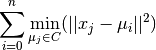

In [1]:
from IPython.display import Image
Image('kmeans.png')

In [49]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by forum
    ''', sklearnConn)
apple78Df.head()

,forum,subject,term,keyword,content,pageurl
0,3c,宅宅注意 漫博會預購新品搶先曝光,漫畫 博覽會 登場 業者 網路 蘋果 副刊 曝光 最愛 新品 曼迪 新品 目的 王子 低音 ...,刀劍亂舞 刀劍亂舞 刀劍亂舞 木棉花 木棉花 木棉花 曼迪 曼迪 曼迪 長門 長門 安枕 安...,全體漫迷，預備備，漫畫博覽會即將在8/11~8/16登場，不少業者搶先推網路預購，《蘋果》副...,http://www.appledaily.com.tw/realtimenews/arti...
1,3c,這台家電 醫師說3族群保命必買！,過敏 鼻炎 氣喘 患者 空氣 清淨 家庭 家電 台北 慈濟 醫院 耳鼻喉科 主治 醫師 族群...,空氣 空氣 空氣 空氣 空氣 空氣 空氣 空氣 空氣 空氣 空氣 空氣 空氣 清淨 清淨 清...,過敏性鼻炎、氣喘等患者居高不下，讓空氣清淨機成為許多家庭必備的小家電。台北慈濟醫院耳鼻喉科主...,http://www.appledaily.com.tw/realtimenews/arti...
2,3c,【終於來了】LINE聊天記錄可備份,頭轉 科技 腳步 蘋果 副刊 3C 亮點 LINE 用戶 蜘蛛絲 iPhone 聊天 備份 ...,備份 備份 備份 備份 line line line line line 多媒體 多媒體 多...,本周熱到暈頭轉向，沒追上科技圈腳步，就跟著《蘋果》副刊3C來回顧一下本周亮點。LINE用戶等...,http://www.appledaily.com.tw/realtimenews/arti...
3,3c,日本推手機散熱器 降溫你那快爆炸的電話,多人 經驗 手機 程式 更新 手機 手機 日本 推出 手機 散熱器 電扇 手機 手機 緊急 ...,手機 手機 手機 手機 手機 手機 手機 手機 充電器 充電器 時刻 時刻 散熱器 緊急 緊...,許多人都有這樣的經驗，手機上的執行程式太多，或是不斷更新，導致就算手機沒有使用中，整個手機也...,http://www.appledaily.com.tw/realtimenews/arti...
4,3c,暑假出國 旅遊APP滑行程還能抽獎,一站式 旅遊 體驗 平台 未來 趨勢 App 電子 票券 服務 一站式 旅遊 體驗 服務 A...,app app app app app app app 東京 東京 東京 東京 東京 票券 ...,一站式旅遊體驗平台Klook客路看準未來趨勢，透過App一鍵快速下訂及整合電子票券等服務，特...,http://www.appledaily.com.tw/realtimenews/arti...


In [31]:
# 轉換後的矩陣資料預覽
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
vec = TfidfVectorizer()
X = vec.fit_transform(apple78Df.term)
ftrs = np.array(vec.get_feature_names())
no1 = pd.Series(X[0].toarray().ravel())
indices = no1[no1 != 0].index
ftrs = np.array(vec.get_feature_names())
df = pd.DataFrame(data=X[0:1000, indices].toarray(), columns=ftrs[indices])
df.head(20)

,live,love,sunshine,上身,中心,低音,刀劍,刀劍亂舞,副刊,加州,...,群英,聲優,背包,航海王,蘋果,角色,論壇,超人,鈴木,長門
0,0.091882,0.084723,0.115919,0.078006,0.026578,0.120756,0.21339,0.354283,0.109677,0.067548,...,0.10765,0.204336,0.076527,0.099889,0.090326,0.057608,0.011930,0.090389,0.077051,0.258051
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.021504,0.000000,0.008521,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.026286,0.000000,0.00000,0.000000,0.108470,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.059555,0.000000,0.011799,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.049347,0.000000,0.00000,0.000000,0.101816,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.111802,0.000000,0.022150,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011194,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.035230,0.000000,0.013959,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.103865,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.057026,0.000000,0.022596,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.054353,0.000000,0.021536,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.179584,0.000000,0.000000,0.026462,0.101260,0.010485,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.031602,0.060465,0.012522,0.000000,0.000000,0.000000


In [4]:
# k-means 嘗試分群頻果新聞 - 1
# 分13群, 因為原始資料本來就是分類為13群
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
vec = TfidfVectorizer()
X = vec.fit_transform(apple78Df.term)
# kmeans = KMeans(n_clusters=13)
# MiniBatchKMeans 分群會差一點但是速度很快, 因為有抽樣分群
kmeans = MiniBatchKMeans(n_clusters=13, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
kData = kmeans.fit_predict(X)
kData = pd.Series(kData)
kData.value_counts()

2     17444
3      3558
8      3098
12     2584
4      1804
1      1632
0      1532
5      1293
10     1140
9       810
11      660
6       647
7       423
dtype: int64

1. sklearn用KL散度 (https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%AF%B9%E7%86%B5) 去算出Homogeneity, Completeness, V-measure (V-measure應該就是F1-Score => 2 x precision x recall / (precision + recall ))

2. 基本上KL散度是在說明兩群資料分部的差異性... 這邊已經搞不懂了, 只要知道這三個value越高代表越好就對了!!
3. 官網解釋
  - homogeneity: each cluster contains only members of a single class.
  - completeness: all members of a given class are assigned to the same cluster.
4. 可以想成 Homogeneity = precision, Completeness = recall, 所以自然 V-measure = F1-Score

In [5]:
# 驗證 k-means分群後跟答案的同質性(Homogeneity), 完備性(Completeness)等等
# Homogeneity, Completeness V-measure 越高越好
# 看Homogeneity分數是滿慘的...,
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics

# adjusted_rand_score 也是越高越好
print("Homogeneity: %0.3f" % metrics.homogeneity_score(apple78Df.forum.values, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(apple78Df.forum.values, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(apple78Df.forum.values, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"  % metrics.adjusted_rand_score(apple78Df.forum.values, kmeans.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

Homogeneity: 0.296
Completeness: 0.348
V-measure: 0.320
Adjusted Rand-Index: 0.102
Silhouette Coefficient: 0.007


In [50]:
grp = 2
print('# 不知道 k-means的{}號群組是對應到哪一個新聞分類, 只知道最多的是life分類, 不過看混亂程度就知道效果非常的不理想!'.format(grp))
print(apple78Df[kData == grp].groupby('forum').size())
print('')
apple78Df[kData == grp] # (apple78Df.forum == 'animal')

# 不知道 k-means的2號群組是對應到哪一個新聞分類, 只知道最多的是life分類, 不過看混亂程度就知道效果非常的不理想!


NameError: name 'apple78Df' is not defined

In [38]:
# 給定3篇文章分詞後結果, 文章 #0, #1 看起來似乎同類, #2自成一類
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
termMxRaw = [
    '電影 電視 難看',
    '電影 電視 難看 難看 難看 難看 難看 難看 難看 難看 難看 難看 難看 難看 難看',
    'iphone7 Note7 爆炸'
]
vec = CountVectorizer()
termMx = vec.fit_transform(termMxRaw)
print(termMx.toarray().shape)
df = pd.DataFrame(columns=vec.get_feature_names(), data=termMx.toarray())
df['tag'] = ['movie', 'movie', 'other']
df

(3L, 6L)


,iphone7,note7,爆炸,難看,電影,電視,tag
0,0,0,0,1,1,1,movie
1,0,0,0,13,1,1,movie
2,1,1,1,0,0,0,other


In [46]:
# 以KNN來看, 其實轉化成像量後 [#0, #2]: 2.23606798 反而比較近, [#0, #1]: 12較遠
# 用kmeans分群, 果然#0, #2被分為同一群, 結果大錯特錯!
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(termMx.toarray())
distances, indices = nbrs.kneighbors(termMx.toarray())

print(indices)
print(distances)

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
# kmeans = KMeans(n_clusters=2)
kmeans = MiniBatchKMeans(n_clusters=2, init='k-means++', n_init=1, init_size=1000, batch_size=1000)
kd = kmeans.fit_predict(termMx)
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df.tag.values, kmeans.labels_))
kd = pd.Series(kd)
print(kd)
df[kd == 1]

[[0 2 1]
 [1 0 2]
 [2 0 1]]
[[  0.           2.44948974  12.        ]
 [  0.          12.          13.19090596]
 [  0.           2.44948974  13.19090596]]

Homogeneity: 0.274
0    1
1    0
2    1
dtype: int32


,iphone7,note7,爆炸,難看,電影,電視,tag
0,0,0,0,1,1,1,movie
2,1,1,1,0,0,0,other


# 用TfidfVectorizer去向量化原來的參數

In [15]:
vec = TfidfVectorizer()
termMx = vec.fit_transform(termMxRaw)
df = pd.DataFrame(columns=vec.get_feature_names(), data=termMx.toarray())
df['tag'] = ['movie', 'movie', 'other']
df

,小飛俠,蝙蝠俠,難看,電影,電視,tag
0,0.000000,0.000000,0.577350,0.577350,0.577350,movie
1,0.000000,0.000000,0.994135,0.076472,0.076472,movie
2,0.707107,0.707107,0.000000,0.000000,0.000000,other


In [20]:
# 以KNN來看, TfidfVectorizer轉化成像量後 [#0, #1]: 0.82186839 [#0, #2]: 1.41421356, 變成#0, #1近, #2被孤立
# 用kmeans分群, 果然#0, #1被分為同一群, 結果就正確了
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(termMx.toarray())
distances, indices = nbrs.kneighbors(termMx.toarray())

print(indices)
print(distances)
print()

from sklearn.cluster import KMeans
from sklearn import metrics
kmeans = KMeans(n_clusters=2)
kd = kmeans.fit_predict(termMx)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df.tag.values, kmeans.labels_))
kd = pd.Series(kd)
print(kd)
df[kd == 0]

[[0 1 2]
 [1 0 2]
 [2 0 1]]
[[ 0.          0.82186839  1.41421356]
 [ 0.          0.82186839  1.41421356]
 [ 0.          1.41421356  1.41421356]]

Homogeneity: 1.000
0    0
1    0
2    1
dtype: int32


,小飛俠,蝙蝠俠,難看,電影,電視,tag
0,0,0,0.577350,0.577350,0.577350,movie
1,0,0,0.994135,0.076472,0.076472,movie


# 試著normalize原始資料, 把它變成標準常態分配, 再來看看k-means結果

In [41]:
from sklearn.preprocessing import StandardScaler, normalize
termMx = CountVectorizer().fit_transform(termMxRaw)
# scaler = StandardScaler().fit(termMx.toarray())
# termMx = scaler.transform(termMx.toarray())
termMx = normalize(termMx.toarray())
df = pd.DataFrame(columns=vec.get_feature_names(), data=termMx)
df['tag'] = ['movie', 'movie', 'other']
df

,小飛俠,蝙蝠俠,難看,電影,電視,tag
0,0.000000,0.000000,0.577350,0.577350,0.577350,movie
1,0.000000,0.000000,0.994135,0.076472,0.076472,movie
2,0.707107,0.707107,0.000000,0.000000,0.000000,other


In [42]:
# 以KNN來看, StandardScaler標準化後的資料, #0, #1近, #2被孤立
# 用kmeans分群, 果然#0, #1被分為同一群, 結果就正確了
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(termMx)
distances, indices = nbrs.kneighbors(termMx)

print(indices)
print(distances)
print()

from sklearn.cluster import KMeans
from sklearn import metrics
kmeans = KMeans(n_clusters=2)
kd = kmeans.fit_predict(termMx)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df.tag.values, kmeans.labels_))
kd = pd.Series(kd)
print(kd)
df[kd == 0]

[[0 1 2]
 [1 0 2]
 [2 1 0]]
[[ 0.          0.82186839  1.41421356]
 [ 0.          0.82186839  1.41421356]
 [ 0.          1.41421356  1.41421356]]

Homogeneity: 1.000
0    0
1    0
2    1
dtype: int32


,小飛俠,蝙蝠俠,難看,電影,電視,tag
0,0,0,0.577350,0.577350,0.577350,movie
1,0,0,0.994135,0.076472,0.076472,movie


Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
For n_clusters = 2 The average silhouette_score is : 0.704978749608


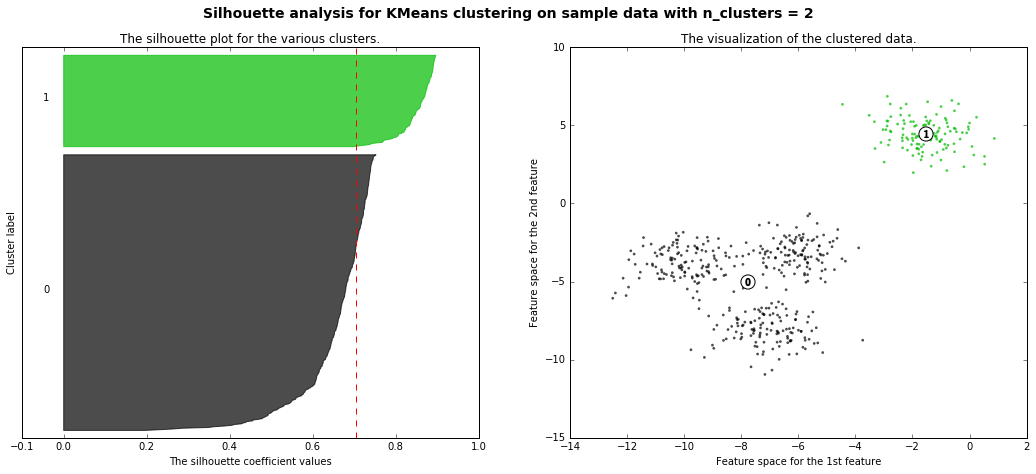

For n_clusters = 3 The average silhouette_score is : 0.588200401213


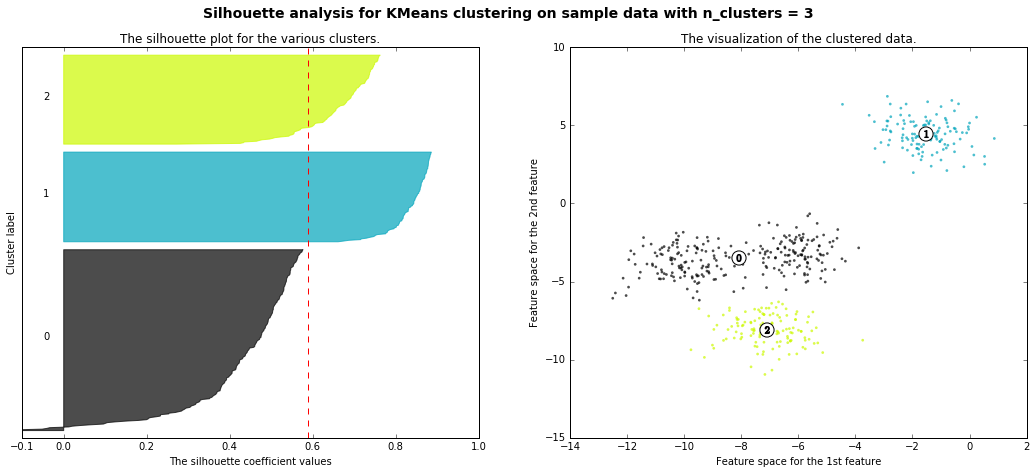

For n_clusters = 4 The average silhouette_score is : 0.650518663273


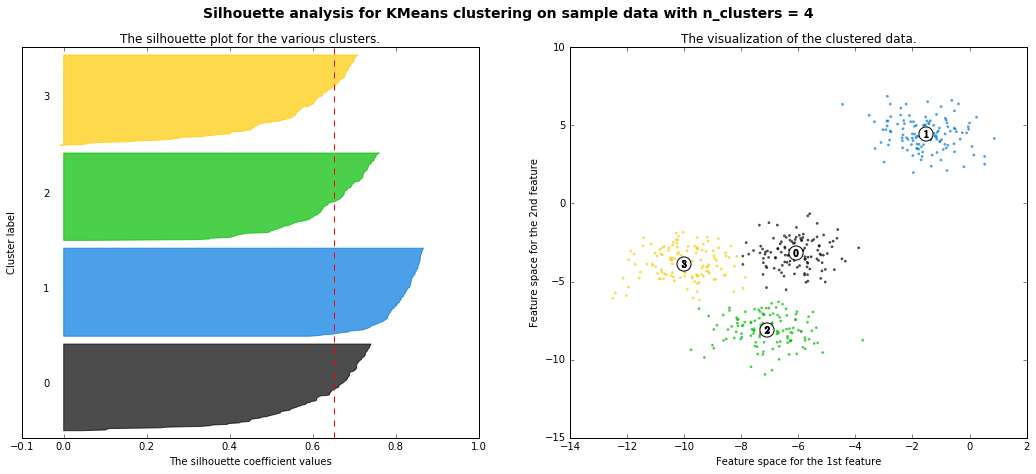

For n_clusters = 5 The average silhouette_score is : 0.563764690262


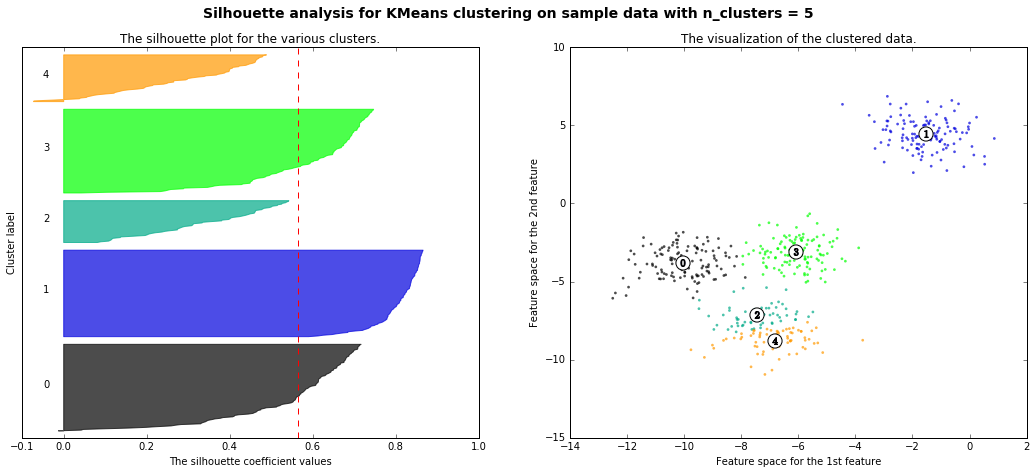

For n_clusters = 6 The average silhouette_score is : 0.450466629437


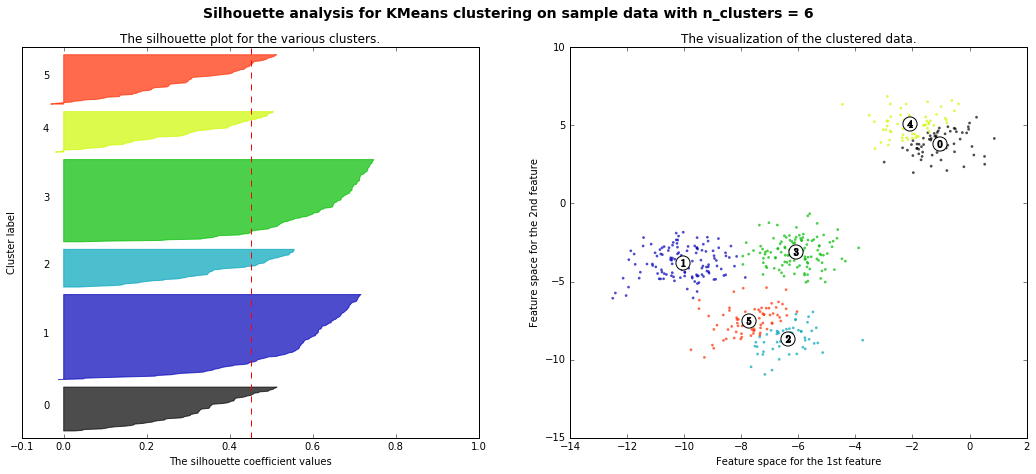

In [21]:
# 官網範例: 用average silhouette width決定分幾群比較好

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distict cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    # print('len of sample_silhouette_values: {}'.format(len(sample_silhouette_values)))

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

https://rpubs.com/skydome20/R-Note9-Clustering


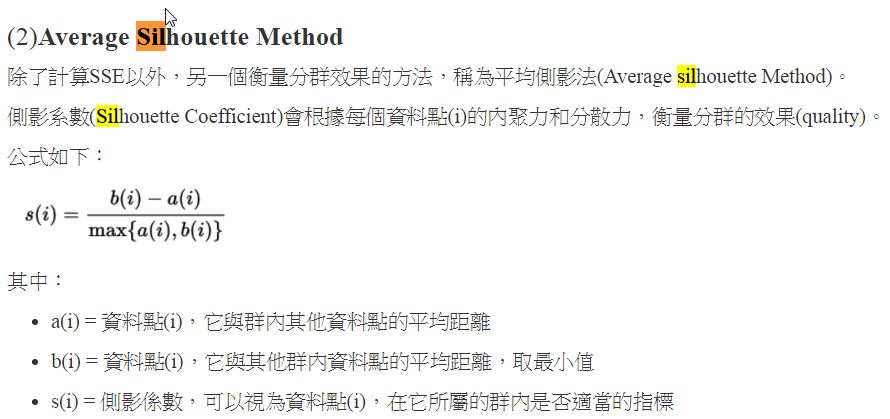

In [48]:
# average silhouette analysis 輪廓分析算法
print('https://rpubs.com/skydome20/R-Note9-Clustering')
from IPython.display import Image
Image('Average_Silhouette.jpg')

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.38s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.37s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.06s    70804   0.671   0.698   0.684   0.561   0.668    0.118
_______________________________________________________________________________


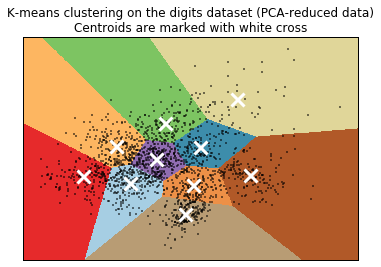

In [24]:
# 官網的範例 => 把分群給視覺化, 使用PCA降低到2維才能畫圖
# 有使用 preprocessing.scale 將原始資料作單位化(unit variance)

print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()